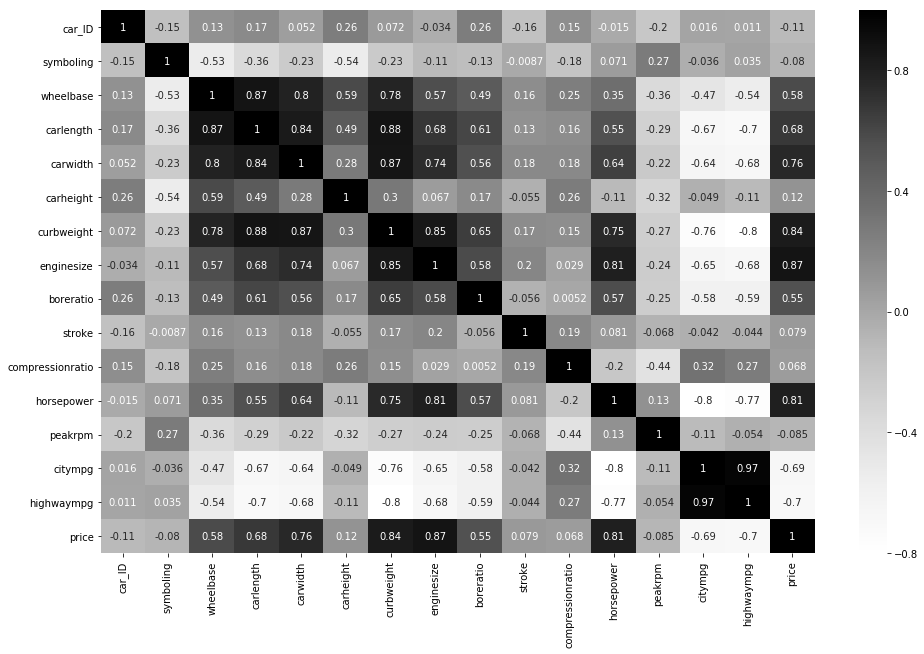

      horsepower  enginesize
0.05        62.0        90.0
0.95       180.8       201.2


,fueltype,aspiration,doornumber,enginelocation,carheight,boreratio,stroke,compressionratio,peakrpm,price,...,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,companyDivision_expensive,companyDivision_moderate
0,1,1,0,1,48.8,3.47,2.68,9.0,5000,13495.0,...,0,0,0,0,0,1,0,0,0,1
1,1,1,0,1,48.8,3.47,2.68,9.0,5000,16500.0,...,0,0,0,0,0,1,0,0,0,1
2,1,1,0,1,52.4,2.68,3.47,9.0,5000,16500.0,...,0,0,0,0,0,1,0,0,0,1
3,1,1,1,1,54.3,3.19,3.40,10.0,5500,13950.0,...,0,0,0,0,0,1,0,0,0,1
4,1,1,1,1,54.3,3.19,3.40,8.0,5500,17450.0,...,0,0,0,0,0,1,0,0,0,1


In [58]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

##Imports ends
##-----------------------------------------------------------------------------

cars_df = pd.read_csv('CarPrice_Assignment.csv')

##
##-----------------------------------------------------------------------------

#Util to get sorted VIF
def getVIF(X_train):
    vif = pd.DataFrame()
    X = X_train
    vif['Columns'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

##Drops the given column and fit OLS and prints summary
def dropColumnFitAndShowSummary(X_train,colName):
    
    if colName != '':
        X_train.drop(colName,axis=1,inplace=True)
    
    # Adding a constant variable  
    X_train = sm.add_constant(X_train)
    lm = sm.OLS(y_train,X_train).fit() 
    print(lm.summary())
    return X_train, lm

def binary_map(x,colValue):
    if(x==colValue):
        return 1
    return 0

##All Kind of preprocessing and data cleaning
def preprocessing(cars_df):
    
    #Not Used
    cars_df.drop('car_ID',axis=1,inplace=True)
    
    #Extracting company names
    cars_df['companyName'] = cars_df['CarName'].apply(lambda x: x.split(" ")[0])
    cars_df.drop('CarName',axis=1,inplace=True)

    # Correcting the misspelled company names.
    cars_df['companyName'].replace('vw','volkswagen',inplace=True)
    cars_df['companyName'].replace('vokswagen','volkswagen',inplace=True)
    cars_df['companyName'].replace('toyouta','toyota',inplace=True)
    cars_df['companyName'].replace('maxda','mazda',inplace=True)
    cars_df['companyName'].replace('porcshce','porsche',inplace=True)
    cars_df['companyName'].replace('Nissan','nissan',inplace=True)
    
    def differentCarSegments(x):
        if x>=20000:
            return 'expensive'
        elif x>=10000:
            return 'moderate'
        return 'cheap'
    
    #Put companies in different segments using mean prices of the companies
    cars_df['companyDivision'] = cars_df['price'].apply(lambda x: differentCarSegments(x))
    cars_df.drop('companyName',axis=1,inplace=True)
    
    print(cars_df[['horsepower','enginesize']].quantile([0.05, .95]))
    
    # Outilers in horsepower','enginesize
    cars_df['horsepower'][np.abs(cars_df['horsepower'] > 180.8)]= 180.8
    cars_df['enginesize'][np.abs(cars_df['enginesize'] > 201.2)]= 201.2
    cars_df['horsepower'][np.abs(cars_df['horsepower'] < 62.0)] = 62.0
    cars_df['enginesize'][np.abs(cars_df['enginesize'] < 90.0)] = 90.0
    
    ##High corelated columns: length the wheel base
    ##width and curbweight
    ##enginesize and horsepower
    ##citympg and highwaympg
    
    cars_df['lengthToWidthRatio'] = cars_df.carlength/cars_df.wheelbase
    cars_df['widthToCurbRatio'] = cars_df.carwidth/cars_df.curbweight
    cars_df['engsizeToHPRatio'] = cars_df.enginesize/cars_df.horsepower
    cars_df['carMilegeratio'] = cars_df.citympg/cars_df.highwaympg
    
    ## droping the orignal variables
    cars_df.drop(['carlength','wheelbase','carwidth','horsepower','curbweight','enginesize','citympg','highwaympg'],axis=1,inplace=True)
    
    ##BINARY CLASSIFICATION
    cars_df['fueltype'] = cars_df['fueltype'].apply(lambda x: binary_map(x,"gas"))
    cars_df['aspiration'] = cars_df['aspiration'].apply(lambda x: binary_map(x,"std"))
    cars_df['doornumber'] = cars_df['doornumber'].apply(lambda x: binary_map(x,"four"))
    cars_df['enginelocation'] = cars_df['enginelocation'].apply(lambda x: binary_map(x,"front"))
    
    ##CREATE DUMMIES
    cars_df['symboling'] = cars_df['symboling'].map({-2: 'muchsafe',-1: 'safe',0: 'moderate',1: 'moderate',2: 'risky',3:'veryrisky'})
    cars_df = pd.get_dummies(cars_df)
    
    # Droping 1 dummy variable and Keeping n-1 varaibles for each feature 
    cars_df.drop(['symboling_veryrisky','enginetype_l','drivewheel_4wd','companyDivision_cheap','fuelsystem_1bbl','carbody_hatchback','cylindernumber_three'],axis=1,inplace=True)
    
    return cars_df
     
##---------------------------------------------------------------------------------------


cars_df.head() 

plt.figure(figsize = (16, 10))
cor=cars_df.corr()
sns.heatmap(cor, annot = True, cmap="Greys")
plt.show()

##--------------DO PREPROCESSING-------
cars_df = preprocessing(cars_df)
##-------------------------------------

cars_df.head()
#cars_df.columns`

In [59]:
##MODEL REGRESSION STARTS

##SPLIT 30-70
df_train, df_test = train_test_split(cars_df, train_size = 0.7, test_size = 0.3, random_state = 100)

#Scaling
scaler = MinMaxScaler()
num_vars = ['boreratio','lengthToWidthRatio','widthToCurbRatio','engsizeToHPRatio','carMilegeratio','stroke','compressionratio','peakrpm','price']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.transform(df_test[num_vars])

#df_train.describe()

y_train = df_train.pop('price')
X_train = df_train

y_test = df_test.pop('price')
X_test = df_test

lm = LinearRegression()
lm.fit(X_train, y_train)

##USING RFE WITH 15 FEATURES
rfe = RFE(lm, 15)             
rfe = rfe.fit(X_train, y_train)

#NEW DATAFRAME WITH THE SELECTED 15 ATTRIBUTES BY RFE
X_train_rfe = X_train[X_train.columns[rfe.support_]]

##Fit once without any dropping
X_train_rfe, lm = dropColumnFitAndShowSummary(X_train_rfe,'')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     120.5
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           1.65e-66
Time:                        10:54:43   Log-Likelihood:                 206.57
No. Observations:                 143   AIC:                            -383.1
Df Residuals:                     128   BIC:                            -338.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [60]:
##High P Value
X_train_rfe, lm = dropColumnFitAndShowSummary(X_train_rfe,'fueltype')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     120.5
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           1.65e-66
Time:                        10:54:46   Log-Likelihood:                 206.57
No. Observations:                 143   AIC:                            -383.1
Df Residuals:                     128   BIC:                            -338.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [61]:
##High P Value
X_train_rfe, lm = dropColumnFitAndShowSummary(X_train_rfe,'enginetype_dohcv')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     128.1
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           4.98e-67
Time:                        10:54:55   Log-Likelihood:                 205.16
No. Observations:                 143   AIC:                            -382.3
Df Residuals:                     129   BIC:                            -340.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [62]:
#Printing VIF
print(getVIF(X_train_rfe))

                      Columns     VIF
0                       const  221.34
12             fuelsystem_idi   96.00
4            compressionratio   79.82
5            widthToCurbRatio    4.88
6            engsizeToHPRatio    3.99
1                  aspiration    3.84
3                   boreratio    3.34
10        cylindernumber_four    3.00
13  companyDivision_expensive    2.41
8            enginetype_rotor    1.70
7             enginetype_ohcf    1.63
11      cylindernumber_twelve    1.36
9        cylindernumber_eight    1.22
2              enginelocation    1.19


In [63]:
##High VIF
X_train_rfe, lm = dropColumnFitAndShowSummary(X_train_rfe,'fuelsystem_idi')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     123.3
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           7.37e-65
Time:                        10:55:10   Log-Likelihood:                 196.87
No. Observations:                 143   AIC:                            -367.7
Df Residuals:                     130   BIC:                            -329.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [64]:
####High P Value
X_train_rfe, lm = dropColumnFitAndShowSummary(X_train_rfe,'aspiration')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     133.4
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           1.65e-65
Time:                        10:55:19   Log-Likelihood:                 195.79
No. Observations:                 143   AIC:                            -367.6
Df Residuals:                     131   BIC:                            -332.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [65]:
##High P Value
X_train_rfe, lm = dropColumnFitAndShowSummary(X_train_rfe,'enginetype_rotor')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     141.1
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           2.13e-65
Time:                        10:55:31   Log-Likelihood:                 192.76
No. Observations:                 143   AIC:                            -363.5
Df Residuals:                     132   BIC:                            -330.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [66]:
print(getVIF(X_train_rfe))

                      Columns     VIF
0                       const  215.07
4            widthToCurbRatio    3.54
2                   boreratio    2.98
8         cylindernumber_four    2.25
10  companyDivision_expensive    2.09
5            engsizeToHPRatio    1.94
3            compressionratio    1.79
6             enginetype_ohcf    1.57
7        cylindernumber_eight    1.21
1              enginelocation    1.17
9       cylindernumber_twelve    1.07


In [67]:
##High P Value
X_train_rfe, lm = dropColumnFitAndShowSummary(X_train_rfe,'compressionratio')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     153.9
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           8.23e-66
Time:                        10:55:54   Log-Likelihood:                 191.02
No. Observations:                 143   AIC:                            -362.0
Df Residuals:                     133   BIC:                            -332.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [56]:
##KEEPING engsizeToHPRatio AS VERY IMPORTANT BUSINESS USE

In [68]:
##High P Value
X_train_rfe, lm = dropColumnFitAndShowSummary(X_train_rfe,'cylindernumber_twelve')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     166.5
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           9.99e-66
Time:                        10:56:15   Log-Likelihood:                 188.01
No. Observations:                 143   AIC:                            -358.0
Df Residuals:                     134   BIC:                            -331.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [69]:
print(getVIF(X_train_rfe))
##All VIFs are below 5

                     Columns     VIF
0                      const  214.99
3           widthToCurbRatio    3.32
2                  boreratio    2.98
7        cylindernumber_four    2.24
8  companyDivision_expensive    2.03
5            enginetype_ohcf    1.57
1             enginelocation    1.17
4           engsizeToHPRatio    1.17
6       cylindernumber_eight    1.17


In [70]:
##Predict Y values in training set
y_train_price = lm.predict(X_train_rfe)

Text(0.5, 0, 'Errors')

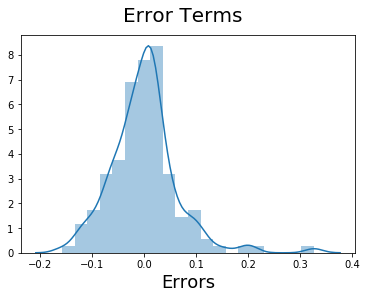

In [71]:
# Error terms plotting
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label


##Proper Error terms distribution:: mean centered towards 0

In [72]:
# Making predictions on test set

# Creating X_test_new dataframe by dropping variables from X_test
X_train_rfe= X_train_rfe.drop(['const'], axis=1)
X_test_new = X_test[X_train_rfe.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [73]:
#Predictions on test set
y_pred = lm.predict(X_test_new)

Text(0, 0.5, 'y_pred')

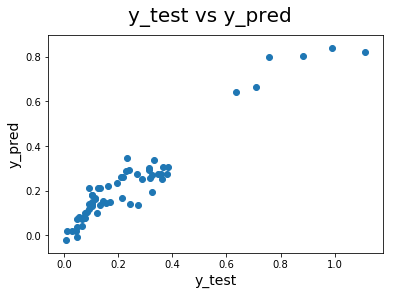

In [74]:

fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=14)                          # X-label
plt.ylabel('y_pred', fontsize=14)                          # Y-label

In [75]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE VALUE FOR MODEL:',rmse)


r2=r2_score(y_test, y_pred)
print('R2_score FOR MODEL:',r2)

RMSE VALUE FOR MODEL: 0.0709400890551482
R2_score FOR MODEL: 0.9058435466441127
